# Reinforcement Learning - Toy examples with Gym

## FrozenLake

In this Notebook, we will implement $SARSA$ and $Q-Learning$ methods to solve the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/), using and comparing different policies for exploration.

Both algorithms update a tabular estimate of the $Q-function$ using a following update rule:
* $SARSA$ algorithm is an on-policy method using:
$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t,a_t))$

* $Q-Learning$ algorithm is an off-policy method using:
$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma \max_b Q_t(s_{t+1}, b) - Q_t(s_t,a_t))$

For exploration, we will compare performances between:
* $\epsilon$-greedy policy with a fixed $\epsilon$.
* $\epsilon$-greedy policy with a decaying $\epsilon$.
* softmax exploration assigning a probability for an action to be
performed according to the following rule:
$P(a_i \vert s) = \frac{e^{\frac{1}{\tau}Q(s,a_j)}}{\sum_j e^{\frac{1}{\tau}Q(s,a_j)}}$

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

c:\environments\drl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Function: chooseAction

Returns an action (integer belonging to the action space of the FrozenLake-v0's environment) given:
* a $Q$-table
* a state
* $\epsilon$
* $softmax$: boolean set to $True$ if softmax exploration is used
* $\tau$: parameter of the softmax exploration.

In [29]:
def chooseAction(q_table, state, epsilon = 0, softmax = True, tau = 0.01):
    if softmax:
        aux = np.exp(q_table[state]/tau)
        d = np.sum(aux)
        return np.random.choice (np.arange(env.action_space.n), p=aux / d)
    if np.random.random () > epsilon:
        return np.argmax(q_table[state])
    return env.action_space.sample()
        

### Function: routine

Body function used to implement both $SARSA$ and $Q$-Learning, since only the estimation of the error changes between the two methods.

* $algo$: either "SARSA" or "QLearning"
* $nEpisode$: number of episodes we simulate to update our $Q$-function
* $\gamma \in [0,1]$: discount factor
* $\alpha \in (0,1]$: learning rate
* $\epsilon_0$: initial value of $\epsilon$
* $\epsilon_{min}$: minimal value of $\epsilon$ if a decaying $\epsilon$ is used
* $decreaseRate \in (0,1]$: geometric parameter of the decaying of $\epsilon$ (set to 1 if no decaying)
* $softmax$: boolean set to $True$ if softmax exploration is used
* $\tau$: parameter of the softmax exploration
* $window$: number of episodes we consider to compute the success rate (or accuracy) of the $Q$-function ; ratio of successes on the last $window$ episodes

In [42]:
def routine(algo, nEpisode = 20000, gamma = 0.99, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = True, softmax = True, tau = 0.01, window = 100):
    accuracy = 0
    epsilon = epsilon0
    q_table = np.ones((env.observation_space.n, env.action_space.n))
    result = np.zeros (window)
    histAcc = [0]
    episode = 0
    
    for _ in range(nEpisode):
        epsilon = max(epsilonMin, 0.999 * epsilon) if decreaseRate else epsilon
        observation0 = env.reset()
        action0 = chooseAction(q_table, observation0, epsilon, softmax, tau)
        done  = False
        for H in range(200):
            observation1, reward, done, info = env.step(action0)
            action1 = chooseAction(q_table, observation1, epsilon, softmax, tau)
            err = reward - q_table[observation0, action0]
            
            if not done:
                if algo == "SARSA":
                    err += gamma * q_table[observation1, action1]
                if algo == "QLearning":
                    err += gamma * q_table[observation1, np.argmax(q_table[observation1])]
            
            q_table[observation0, action0] += alpha * err
            
            if done:
                break
            
            observation0, action0 = observation1, action1

        success = 1 if (reward == 1) else 0
        accuracy += (success - result[episode]) / window
        result[episode] = success
        episode = (episode + 1) % window
        if episode == 0: # accuracy ratio is stored once in @window episodes
            histAcc.append(accuracy)

    return q_table, histAcc

### SARSA

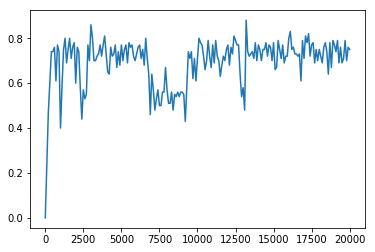

In [49]:
def SARSA(nEpisode = 20000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = True, softmax = True, tau = 0.01, window = 100):
    return routine("SARSA", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)
        
q_table, histAcc = SARSA (20000, softmax = True)
plt.plot(100 * np.arange(len(histAcc)), histAcc)

### $Q$-Learning

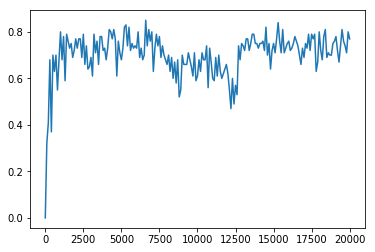

In [47]:
def QLearning(nEpisode = 20000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = True, softmax = True, tau = 0.003, window = 100):
    return routine("QLearning", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)

q_table, histAcc = QLearning (20000, softmax = True)
plt.plot(100 * np.arange(len(histAcc)), histAcc)

In [46]:
def testPolicy (q_table, nEpisode = 2000):
    success = 0
    for _ in range(nEpisode):
        t = 0
        observation = env.reset()
        done  = False
        while not done and t < 200:
            action = np.argmax(q_table[observation])
            observation, reward, done, info = env.step(action)
            t += 1

        if reward == 1:
            success += 1
    return success / nEpisode

for _ in range(5):
    q_table, histAcc = QLearning (2000, softmax = True)
    print(testPolicy(q_table))
    q_table, histAcc = SARSA (2000, softmax = True)
    print(testPolicy(q_table))

0.738
0.746
0.739
0.7435
0.7385
0.718
0.744
0.754
0.6615
0.6515


In [53]:
np.argmax(q_table, axis = 1).reshape((4,4))

array([[0, 3, 3, 3],
       [0, 0, 0, 0],
       [3, 1, 0, 0],
       [0, 2, 1, 0]], dtype=int64)